# Macro Trends and Factor Timing

In [86]:
import numpy as np
import pandas as pd 
import pandas_datareader as pdr
from fredapi import Fred
from fred_api import fred_api
import os

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

***
## Method

Equation for factors prices: </br>
$$
\ln \mathbf{F}_t=\ln \mathbf{F}_{t-1}+\mathbf{f}_t
$$

Equation for macro driver: </br>
$$
\ln \mathbf{M}_{t+1}=\ln \mathbf{M}_t+\mathbf{m}_{t+1}
$$

Relationship between factor price and drivers: </br>
$$
\ln F_{j, t}=\alpha_{0, j}+\alpha_{1, j} t+\beta_j^{\prime} \ln \mathbf{M}_t+w_{j, t}, \quad j=1, \ldots, k
$$

Basically, this equation suggests that the log factor price is a function of a constant, a trend component and some macro driver. Note that there is also the inclusion of another component which will be defined later

Cointegration logic between factors and macro variables: </br>

$$
\begin{array}{rlr}
\ln F_{j, t+1} & =\alpha_{0, j}+\alpha_{1, j} t+\beta_{j}^{\prime} \ln \mathbf{M}_{t+1}+w_{j, t+1}, & j=1, \ldots, k \\
w_{j, t+1} & =\rho_{j} w_{j, t}+v_{j, t+1} & \\
\end{array}
$$


This is obtained by taken a first difference on the Long-Run cointegrating relationship, and representing $w_{j, t}$ as an AR(1) process.


Transformed equation: </br>
$$
f_{j, t+1}=\alpha_{1, j}+\beta_j^{\prime} \mathbf{m}_{t+1}+\underbrace{\left(\rho_i-1\right)}_{\delta_j} \underbrace{w_{j, t}}_{\equiv E C T_{j, t}}+v_{j, t+1}
$$

Basically, this suggest that the nature of the factor is dependent on the error from its regression. That is, a linear relationship is expected to hold between factor prices and macro drivers and if there is departure from this relationship, there will be an impact on the future price of $f_{j, t+1}$.

$\delta_j$ captures the speed with which the system eliminates disequilibria with respect to the long-run relationship.

ECT equation: </br>
$$
E C T_{j, t} \equiv \ln F_{j, t}-\hat{\alpha}_{0, j}-\hat{\alpha}_{1, j} t-\hat{\beta}_{j}^{\prime} \ln \mathbf{M}_{t}
$$

### Johansen Test Specifications
Link: https://www.statsmodels.org/dev/generated/statsmodels.tsavector_ar.vecm.coint_johansen.html  </br>

Procedure presumes a p-dimensinoalVAR model with k lags, where p corresponds to the number of stochastic variables. </br>

Setting: </br>
p = 5 (FF factors)
k = Determined by the AIC 

$H_0$: $r$ cointegrating relations <br>
$H_1$: $p$ cointegrating relations

Results obtained: Rejection of the null of no cointegration against the alternative of one. Cannot reject the null of one cointegrating relationship agains the alternative of two or more for all factors.

Will probably have to fit a VAR myself because Python doesn't have this option available.

### Predictive regression

Interest lies in understanding the ability of the ECT to predict characteristics-based factor returns. </br> 

$\text { The predictive regression is } f_{j, t+1}=\alpha_{1, j}+\delta_j E C T_{j, t}+v_{j, t+1} \text {. }$

Predicting factors return in quarter $t+1$ using the ECT at time $t$, some robustness tests are also made on other time periods. Results are very encouraging. 

** Results discussed so far are based on a fixed cointegrating vector where the parameters are set equal to their valus estimated in the full sample. 

***
## Data

Two proeminent factor models:

1. Five Factor model of FF (2015)
    - Available using pandas_datareader
    - Quarterly if available, otherwise resampled 
2. q-factor model of Hou, Xue and Zhang (2018)
    - Available at http://global-q.org/factors.html
    - Quarterly if available, otherwise resampled 

Set of economic variables: 
- WTI Crude oil returns as tradable proxy for inflation, available at https://fred.stlouisfed.org/series/WTISPLC
- Potential output, available at https://fred.stlouisfed.org/series/GDPPOT (growth of potential output as integrated of order 1)
- Liquidity factor http://finance.wharton.upenn.edu/~stambaug/
- Term spread, proxied by the difference between 10-year bond and short term rate 

Additional specifications:
- Sample period 1968-2019 
- Quarterly observations and accordingly 3 months holding period excess return

### Factor Data

In [87]:
# Benchmarking with the FF5
start_date = '1968-01-01'
end_date = '2019-12-31'

FF_five_with_rf= pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1900')[0]
FF_five = FF_five_with_rf.drop(columns={'RF'}) / 100
FF_five = FF_five.loc[(FF_five.index >= start_date) & (FF_five.index <= end_date)]
FF_five.index = FF_five.index.to_timestamp()

In [88]:
# Resample to Quarterly Frequency
quarterly_ff = FF_five.resample('Q').apply(lambda x: (1 + x).prod() - 1)
quarterly_ff

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1968-03-31,-0.074731,-0.001446,0.055152,-0.037727,0.078685
1968-06-30,0.123059,0.132945,0.004383,0.016774,-0.028917
1968-09-30,0.025565,0.036613,0.067738,-0.057223,0.051246
1968-12-31,0.017014,0.055490,0.019035,-0.027390,0.019680
1969-03-31,-0.045622,-0.050111,0.020720,-0.009491,0.018637
...,...,...,...,...,...
2018-12-31,-0.151041,-0.079260,0.018019,0.003648,0.042124
2019-03-31,0.133185,0.011434,-0.071577,0.002129,-0.039968
2019-06-30,0.034596,-0.023815,-0.009790,0.020529,-0.009271


In [89]:
# Defining log factors as in Eq 1
log_ff_five = np.log(1 + quarterly_ff).cumsum()
log_ff_five

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1968-03-31,-0.077670,-0.001447,0.053685,-0.038457,0.075743
1968-06-30,0.038386,0.123373,0.058058,-0.021822,0.046399
1968-09-30,0.063630,0.159332,0.123601,-0.080748,0.096375
1968-12-31,0.080501,0.213336,0.142457,-0.108520,0.115864
1969-03-31,0.033805,0.161926,0.162964,-0.118056,0.134329
...,...,...,...,...,...
2018-12-31,2.408152,0.764173,1.763334,1.480083,1.883107
2019-03-31,2.533185,0.775542,1.689066,1.482210,1.842319
2019-06-30,2.567196,0.751439,1.679227,1.502531,1.833004


### Macroeconomic Drivers 

In [90]:
fred = Fred(api_key=fred_api)

In [91]:
#  Potential Output timeseries 
pot = fred.get_series('GDPPOT')
pot

1949-01-01            NaN
1949-04-01            NaN
1949-07-01            NaN
1949-10-01            NaN
1950-01-01    2218.566586
                 ...     
2032-10-01            NaN
2033-01-01            NaN
2033-04-01            NaN
2033-07-01            NaN
2033-10-01            NaN
Length: 340, dtype: float64

In [92]:
# WTI Crude oil timeseries
wti = fred.get_series('WTISPLC')
wti

1946-01-01     1.17
1946-02-01     1.17
1946-03-01     1.17
1946-04-01     1.27
1946-05-01     1.27
              ...  
2023-03-01    73.28
2023-04-01    79.45
2023-05-01    71.58
2023-06-01    70.25
2023-07-01    76.07
Length: 931, dtype: float64

In [107]:
# Stambaugh liquidity series
liq = pd.read_csv('https://finance.wharton.upenn.edu/~stambaug/liq_data_1962_2022.txt', delim_whitespace=True, comment='%', header=None, names=['Month', 'Agg_Liq', 'Innov_Liq', 'Traded_Liq'])
liq = liq[liq['Traded_Liq'] != -99][['Month', 'Traded_Liq']]
liq['Month'] = pd.to_datetime(liq['Month'], format='%Y%m')
liq = liq.set_index(liq['Month']).drop(columns={'Month'})
liq = liq['Traded_Liq']

# Quarterly returns
liq = liq.resample('Q').apply(lambda x: (1 + x).prod() - 1)
liq.index = liq.index + pd.DateOffset(days=1)
liq

Month
1968-04-01    0.004524
1968-07-01   -0.010434
1968-10-01   -0.018037
1969-01-01    0.004804
1969-04-01    0.061910
                ...   
2022-01-01   -0.034326
2022-04-01   -0.067440
2022-07-01   -0.063589
2022-10-01    0.083857
2023-01-01   -0.155307
Name: Traded_Liq, Length: 220, dtype: float64

In [94]:
# Term Spread 
# Difference between 10 years rate and 3 months yield
ten_years_bond = fred.get_series('DGS10')
three_months_bond = fred.get_series('TB3MS')

term_spread = (ten_years_bond.resample('Q').last() - three_months_bond.resample('Q').last()).dropna()
term_spread.index = term_spread.index + pd.DateOffset(days=1)
term_spread

1962-04-01    1.14
1962-07-01    1.27
1962-10-01    1.16
1963-01-01    0.98
1963-04-01    1.06
              ... 
2022-10-01    0.70
2023-01-01   -0.37
2023-04-01   -1.21
2023-07-01   -1.35
2023-10-01   -1.21
Length: 247, dtype: float64

In [111]:
macro_drivers = pd.concat([pot.pct_change().dropna(), wti.pct_change().dropna(), liq, term_spread.diff().dropna() / 10], axis=1, keys=['POT', 'WTI', 'Liquidity', 'Term_Spread']).dropna()
macro_drivers

,POT,WTI,Liquidity,Term_Spread
1968-04-01,0.011180,0.000000,0.004524,-0.014
1968-07-01,0.011169,0.000000,-0.010434,-0.047
1968-10-01,0.011121,0.000000,-0.018037,0.018
1969-01-01,0.010605,0.000000,0.004804,-0.010
1969-04-01,0.010110,0.030769,0.061910,0.008
...,...,...,...,...
2022-01-01,0.005006,0.160508,-0.034326,-0.002
2022-04-01,0.004783,-0.061935,-0.067440,0.042
2022-07-01,0.004557,-0.115117,-0.063589,-0.039
2022-10-01,0.004374,0.039046,0.083857,-0.079


In [112]:
# Cumulative Macro Drivers Returns
log_macro_returns = np.log(1 + macro_drivers).cumsum()

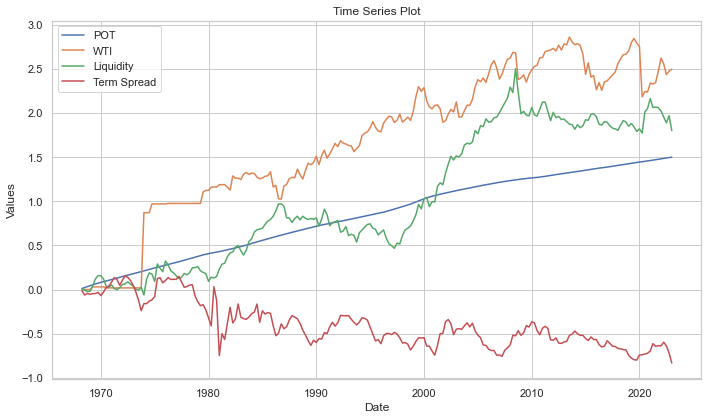

In [113]:
# Set up a nicer style for the plot
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Plot the DataFrame
plt.plot(log_macro_returns.index, log_macro_returns['POT'], label='POT')
plt.plot(log_macro_returns.index, log_macro_returns['WTI'], label='WTI')
plt.plot(log_macro_returns.index, log_macro_returns['Liquidity'], label='Liquidity')
plt.plot(log_macro_returns.index, log_macro_returns['Term_Spread'], label='Term Spread')

# Customize the plot
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

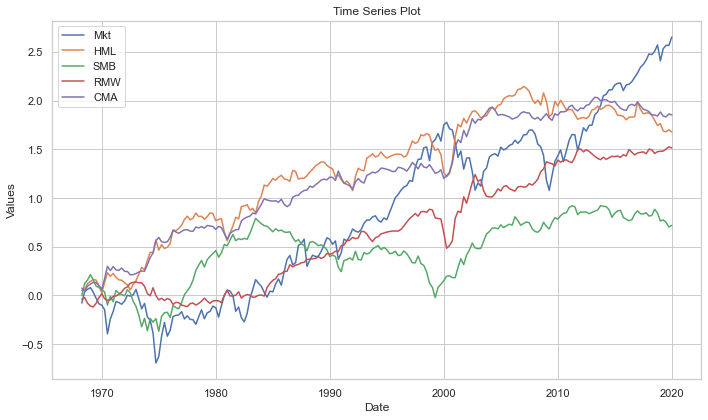

In [98]:
# Set up a nicer style for the plot
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Plot the DataFrame
plt.plot(log_ff_five.index, log_ff_five['Mkt-RF'], label='Mkt')
plt.plot(log_ff_five.index, log_ff_five['HML'], label='HML')
plt.plot(log_ff_five.index, log_ff_five['SMB'], label='SMB')
plt.plot(log_ff_five.index, log_ff_five['RMW'], label='RMW')
plt.plot(log_ff_five.index, log_ff_five['CMA'], label='CMA')


# Customize the plot
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()